In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal, stats, optimize
from fractal_deriv import *
from observer import kfilter

x_file = './roboao_tt/lx_all_library.txt'

In [2]:
f_sampling = 1000
lim = 1000
N = 100
#x_tt = np.genfromtxt(x_file).flatten()[:lim] * 0.0175797 * 2
#x_tt = np.load('keck_tt/OpenLoop_n0088.npy')[:lim,0]
x_tt = np.load('./turbulence.npy')[:,0]

(1e-07, 45.02503225803977)

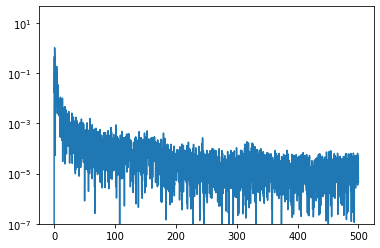

In [3]:
fxx, Pxx = signal.periodogram(x_tt, fs=f_sampling)
plt.semilogy(fxx, Pxx)
plt.ylim(1e-7)

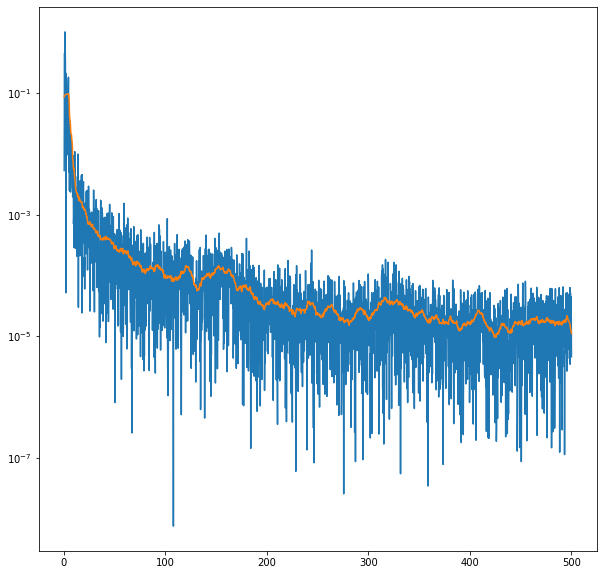

In [4]:
log_psd = -np.log10(Pxx)
size = 20
to_conv = [1/(2*size + 1)] * (2 * size + 1)
clean_psd = np.convolve(Pxx[1:], to_conv)
plt.figure(figsize=(10,10))
plt.semilogy(fxx[1:], Pxx[1:])
plt.semilogy(fxx[1:], clean_psd[size:-size])

clean_psd = clean_psd[size-1:-size]

In [5]:
#stats.linregress(fxx[np.where(fxx < 0.1)], np.log10(clean_psd[np.where(fxx < 0.1)]))

In [6]:
c = stats.linregress(np.log10(fxx[np.where(fxx > 0.1)]), np.log10(clean_psd[np.where(fxx > 0.1)])).slope

In [7]:
a = 1e-6
get_ft = lambda b: b/((1j * fxx + a)**(1/3) * (1j * fxx + 0.1)**(-c/2))
# I suspect you gotta put the -1/3 for lower frequencies, but here the post-wind-clearing component is dominant

def cost(pars):
    b = pars
    return np.mean((np.log10(np.abs(get_ft(b))**2) - np.log10(Pxx))**2)

b = optimize.minimize(cost, [1]).x
print(b)

[1.3520479]


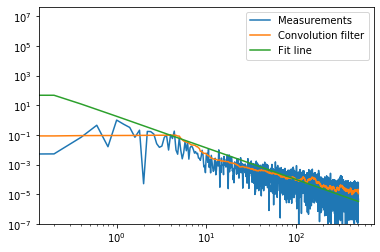

In [8]:
plt.loglog(fxx, Pxx, label='Measurements')
plt.loglog(fxx, clean_psd, label='Convolution filter')
plt.loglog(fxx, np.abs(get_ft(b))**2, label='Fit line')
plt.ylim(1e-7)
plt.legend()

In [17]:
ft = lambda f: b * ((1j * f + a)**(1/3) * (1j * f + 0.1)**(-c/2))

array([15.81048   +1.45995846e-08j, 15.81054175-1.45995846e-08j,
       15.81059602+1.45995846e-08j, 15.81064324-1.45995846e-08j,
       15.81068609+1.45995846e-08j, 15.81072639-1.45995846e-08j,
       15.81076396+1.45995846e-08j, 15.81080002-1.45995846e-08j,
       15.81083409+1.45995846e-08j, 15.81086708-1.45995846e-08j,
       15.8108985 +1.45995846e-08j, 15.81092907-1.45995846e-08j,
       15.81095833+1.45995846e-08j, 15.81098688-1.45995846e-08j,
       15.81101431+1.45995846e-08j, 15.81104113-1.45995846e-08j,
       15.81106696+1.45995846e-08j, 15.81109224-1.45995846e-08j,
       15.81111664+1.45995846e-08j, 15.81114054-1.45995846e-08j,
       15.81116364+1.45995846e-08j, 15.81118628-1.45995846e-08j,
       15.81120817+1.45995846e-08j, 15.81122965-1.45995846e-08j,
       15.81125043+1.45995846e-08j, 15.81127082-1.45995846e-08j,
       15.81129057+1.45995846e-08j, 15.81130993-1.45995846e-08j,
       15.81132869+1.45995846e-08j, 15.81134709-1.45995846e-08j,
       15.81136492+1.4599

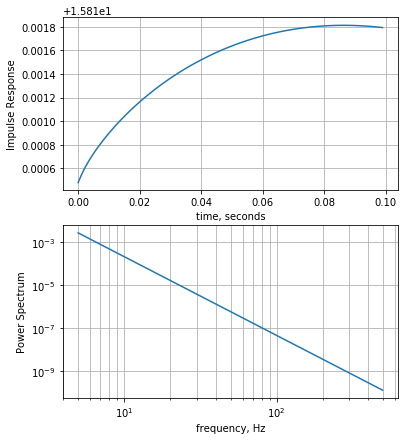

In [34]:
design_filt(dt=1e-3, N=2*N)

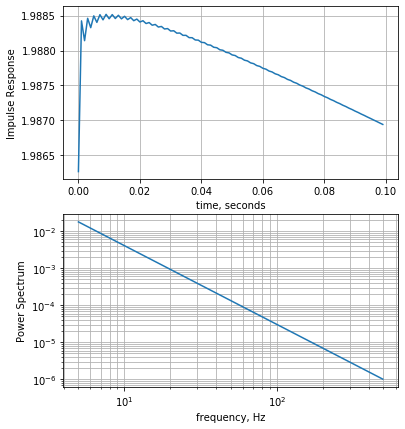

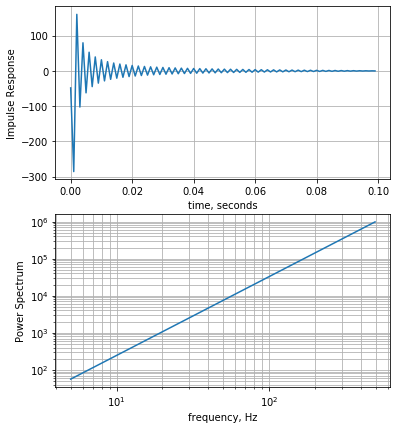

In [45]:
impulse_correct = design_filt(dt=1e-3, N=2*N, tf=lambda f: 1/ft(f))
impulse_track = design_filt(dt=1e-3, N=2*N, tf=ft)

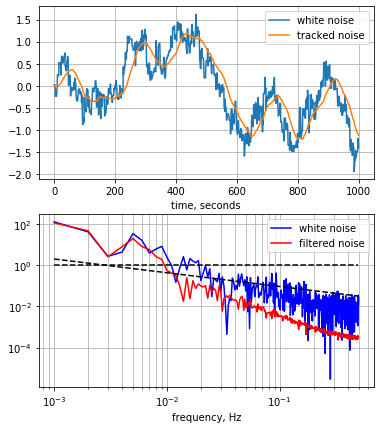

In [36]:
res = filt(impulse_correct, u=x_tt[:lim])

In [46]:
def make_impulse_filter(x):
    # takes in np array x: the impulse response of a filter
    # returns matrices A, P, Q, H, R to augment with the kfilter
    n = x.size
    A = np.zeros((n, n))
    for i in range(1, n):
        A[i][i-1] = 1
    A[0] = np.flip(x)
    # when you start the filter, make sure to start it at time n with the first n measurements identically
    P = np.zeros((n,n))
    Q = np.zeros((n,n))
    Q[0][0] = 1
    H = np.zeros((1,n))
    H[:,0] = 1
    R = np.array([0.04**2])
    return A, P, Q, H, R

A, P, Q, H, R = make_impulse_filter(impulse_track)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [58]:
# now, let's Kalman filter with this
measurements = x_tt + np.random.normal(0, 0.04, x_tt.shape)
rms = lambda data: np.sqrt(np.mean(data ** 2))
kfiltered = kfilter((measurements[:N], A, P, Q/100, H, R), measurements[N:lim])

steady state at step  298


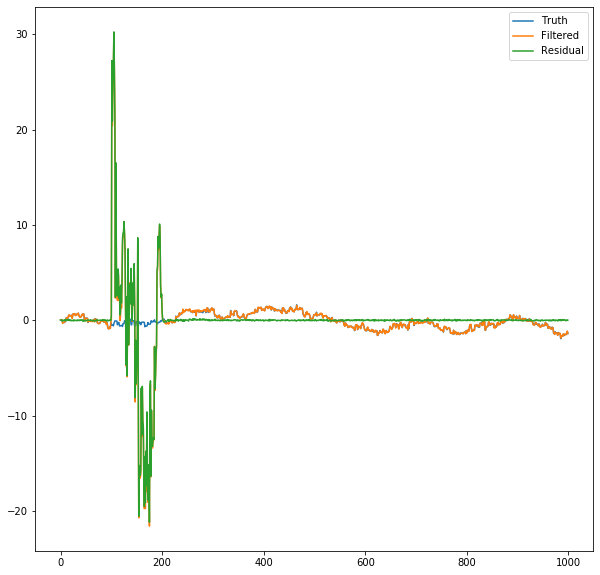

In [59]:
plt.figure(figsize=(10,10))
filtered = np.hstack((measurements[:N], kfiltered))
plt.plot(x_tt[:lim], label='Truth')
plt.plot(filtered, label='Filtered')
residual = filtered - x_tt[:lim]
plt.plot(residual, label='Residual')
plt.legend()

In [60]:
rms(residual[500:])

0.04060428562088264

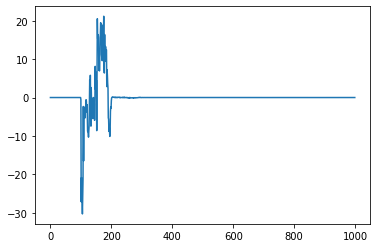

In [61]:
# the 'are you just tracking measurements' plot
plt.plot(measurements[:lim] - filtered[:lim])